# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 9

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [ ]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [41]:
# ===========================================================
# PART 2: DATA SPLITTING
# ===========================================================
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_full.numpy(),
    y_full.numpy(),
    test_size=0.3,
    random_state=GROUP_NUMBER
)

# Convert back to PyTorch Tensors for training
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

print(f"✅ Data Split Complete:")
print(f"   Training Set:   {X_train.shape[0]} samples")
print(f"   Validation Set: {X_val.shape[0]} samples")

✅ Data Split Complete:
   Training Set:   2100 samples
   Validation Set: 900 samples


In [42]:
# ===========================================================
# PART 3: The Manual Architecture & Loss Calculation
# ===========================================================

class ManualMLP:
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=1):
        self.params = []

        # Layer 1
        self.W1 = torch.randn(input_dim, hidden_dim) * np.sqrt(2. / input_dim)
        self.b1 = torch.zeros(1, hidden_dim)

        # Layer 2
        self.W2 = torch.randn(hidden_dim, hidden_dim) * np.sqrt(2. / hidden_dim)
        self.b2 = torch.zeros(1, hidden_dim)

        # Layer 3
        self.W3 = torch.randn(hidden_dim, hidden_dim) * np.sqrt(2. / hidden_dim)
        self.b3 = torch.zeros(1, hidden_dim)

        # Layer 4
        self.W4 = torch.randn(hidden_dim, output_dim) * np.sqrt(1. / hidden_dim)
        self.b4 = torch.zeros(1, output_dim)

        # Registering parameters for gradient tracking
        for p in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]:
            p.requires_grad = True
            self.params.append(p)

    def relu(self, x):
        #Defining ReLU activation: max(0, x)
        return torch.maximum(x, torch.tensor(0.0))

    def sigmoid(self, x):
        #Defining ReLU activation: 1 / (1 + e^-x)
        return 1.0 / (1.0 + torch.exp(-x))

    def forward(self, X):
        #Forward pass using raw matrix multiplication
        # Layer 1
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)

        # Layer 2
        z2 = a1 @ self.W2 + self.b2
        a2 = self.relu(z2)

        # Layer 3
        z3 = a2 @ self.W3 + self.b3
        a3 = self.relu(z3)

        # Layer 4 (Output)
        z4 = a3 @ self.W4 + self.b4
        a4 = self.sigmoid(z4)

        return a4

# -Manual Binary Cross Entropy Loss
def manual_bce_loss(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    loss = -1 * torch.mean(
        y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)
    )
    return loss

def calculate_accuracy(y_pred, y_true):
    predicted_classes = (y_pred > 0.5).float()
    correct = (predicted_classes == y_true).float().sum()
    return correct / y_true.shape[0]

print("Model Architecture Defined.")

Model Architecture Defined.


In [43]:
# ===========================================================
# PART 4: Training Loop
# ===========================================================

# Hyperparameters
epochs = 3000
learning_rate = 0.1

# Initializing Model
model = ManualMLP()

# Lists to store history for plotting
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

print(f"Initiating Training:")

for epoch in range(epochs):
    # --- TRAINING STEP ---
    # 1. Forward Pass
    y_pred_train = model.forward(X_train)

    # 2. Computing Loss
    loss = manual_bce_loss(y_pred_train, y_train)

    # 3. Backward Pass (Autograd computes gradients for us)
    loss.backward()

    # 4. Optimization
    # We must use torch.no_grad() so this update isn't tracked in the computation graph
    with torch.no_grad():
        for param in model.params:
            param -= learning_rate * param.grad
            param.grad.zero_()

    with torch.no_grad():
        y_pred_val = model.forward(X_val)
        val_loss = manual_bce_loss(y_pred_val, y_val)

        train_acc = calculate_accuracy(y_pred_train, y_train)
        val_acc = calculate_accuracy(y_pred_val, y_val)

    # Store History
    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())
    history["train_acc"].append(train_acc.item())
    history["val_acc"].append(val_acc.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Acc: {val_acc.item():.4f}")

print(" Model Calibrated.")

Initiating Training:
Epoch 0 | Loss: 2.5286 | Val Acc: 0.5900
Epoch 200 | Loss: 0.6084 | Val Acc: 0.5089
Epoch 400 | Loss: 0.5978 | Val Acc: 0.5700
Epoch 600 | Loss: 0.5793 | Val Acc: 0.6000
Epoch 800 | Loss: 0.5297 | Val Acc: 0.6433
Epoch 1000 | Loss: 0.4653 | Val Acc: 0.7089
Epoch 1200 | Loss: 0.3810 | Val Acc: 0.8411
Epoch 1400 | Loss: 0.3460 | Val Acc: 0.8678
Epoch 1600 | Loss: 0.3222 | Val Acc: 0.8789
Epoch 1800 | Loss: 0.3090 | Val Acc: 0.8867
Epoch 2000 | Loss: 0.3027 | Val Acc: 0.8911
Epoch 2200 | Loss: 0.2983 | Val Acc: 0.8933
Epoch 2400 | Loss: 0.2950 | Val Acc: 0.8956
Epoch 2600 | Loss: 0.2891 | Val Acc: 0.8989
Epoch 2800 | Loss: 0.2872 | Val Acc: 0.9011
 Model Calibrated.


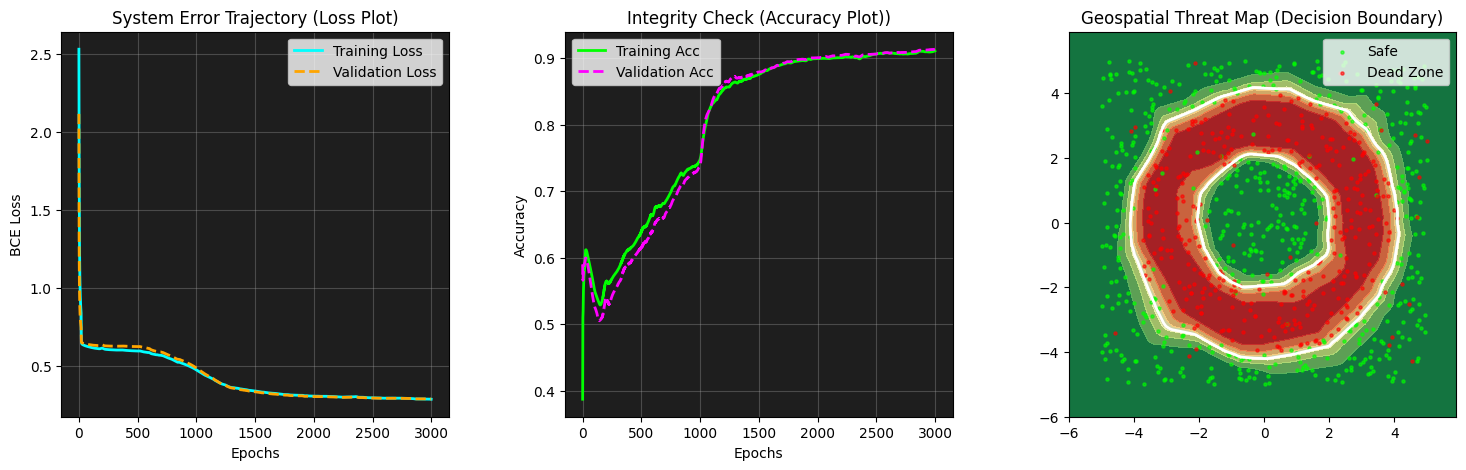

In [44]:
# ===========================================================
# PART 5: (Visualization
# ===========================================================
import pandas as pd

def plot_dashboard(history, model, X_val, y_val):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3)

    def smooth(data):
        return pd.Series(data).rolling(window=20, min_periods=1).mean()

    # PANEL 1: Loss
    axes[0].plot(smooth(history['train_loss']), label='Training Loss', color='cyan', linewidth=2)
    axes[0].plot(smooth(history['val_loss']), label='Validation Loss', color='orange', linestyle='--', linewidth=2)

    axes[0].set_title("System Error Trajectory (Loss Plot)")
    axes[0].set_facecolor('#1e1e1e')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("BCE Loss")

    # PANEL 2: Accuracy
    axes[1].plot(smooth(history['train_acc']), label='Training Acc', color='lime', linewidth=2)
    axes[1].plot(smooth(history['val_acc']), label='Validation Acc', color='magenta', linestyle='--', linewidth=2)

    axes[1].set_title("Integrity Check (Accuracy Plot))")
    axes[1].set_facecolor('#1e1e1e')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")

    # PANEL 3: Decision Boundary
    xx, yy = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        Z = model.forward(grid_tensor).reshape(xx.shape)

    # Plot Contours
    axes[2].contourf(xx, yy, Z, alpha=0.8, cmap='RdYlGn_r')
    axes[2].contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2)

    # Scatter Validation Data
    safe = (y_val.view(-1) == 0)
    dead = (y_val.view(-1) == 1)
    axes[2].scatter(X_val[safe, 0], X_val[safe, 1], c='lime', s=5, alpha=0.6, label='Safe')
    axes[2].scatter(X_val[dead, 0], X_val[dead, 1], c='red', s=5, alpha=0.6, label='Dead Zone')

    axes[2].set_title("Geospatial Threat Map (Decision Boundary)")
    axes[2].set_facecolor('#1e1e1e')
    axes[2].legend(loc='upper right')

    plt.show()

plot_dashboard(history, model, X_val, y_val)